In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SP1 2021-2022.csv to SP1 2021-2022.csv
Saving SP1 2022-2023.csv to SP1 2022-2023.csv
Saving SP1 2023-2024.csv to SP1 2023-2024.csv
Saving SP1 2024-2025.csv to SP1 2024-2025.csv
Saving SP1 2025-2026.csv to SP1 2025-2026.csv


In [ ]:
import pandas as pd
import glob

# 1. Cargar todos los archivos CSV de LaLiga
# (Asegúrate de tener los 5 archivos subidos en el almacenamiento de Colab)
archivos_csv = glob.glob("SP1*.csv")
lista_dataframes = [pd.read_csv(archivo) for archivo in archivos_csv]

# 2. Unir todas las temporadas en un solo DataFrame 📊
df_completo = pd.concat(lista_dataframes, ignore_index=True)

# 3. Definir las columnas estrictamente deportivas
# Excluimos todas las cuotas (B365, Max, Avg...) y datos al descanso (HTHG, HTAG, HTR)
columnas_utiles = [
    'Date', 'Time', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR',     # Goles Local, Goles Visitante y Resultado Final (Full Time)
    'HS', 'AS', 'HST', 'AST',  # Tiros totales y Tiros a puerta (Home/Away)
    'HC', 'AC',                # Córners
    'HF', 'AF',                # Faltas cometidas
    'HY', 'AY', 'HR', 'AR'     # Tarjetas Amarillas y Rojas
]

# 4. Filtrar el dataset para quedarse solo con nuestra selección pura
df_limpio = df_completo[columnas_utiles].copy()

# 5. Formatear la fecha y la hora para ordenar el tiempo real ⏱️
# Juntamos la fecha y la hora en una sola columna para tener el momento exacto del partido
df_limpio['Datetime'] = pd.to_datetime(df_limpio['Date'] + ' ' + df_limpio['Time'], dayfirst=True, format='mixed')

# 6. Ordenar cronológicamente del partido más antiguo al más reciente
# Esto es vital para aplicar la Validación Walk-Forward sin mirar al futuro
df_limpio = df_limpio.sort_values('Datetime').reset_index(drop=True)

# Mostramos el tamaño final del dataset y las primeras 5 filas
print(f"Total de partidos listos: {len(df_limpio)}")
print(df_limpio.head())

Total de partidos listos: 1769
         Date   Time  HomeTeam     AwayTeam  FTHG  FTAG FTR  HS  AS  HST  AST  \
0  13/08/2021  20:00  Valencia       Getafe     1     0   H   4  22    2    4   
1  14/08/2021  18:30     Cadiz      Levante     1     1   D   7  12    2    3   
2  14/08/2021  18:30  Mallorca        Betis     1     1   D   6  10    2    1   
3  14/08/2021  21:00    Alaves  Real Madrid     1     4   A  11  19    4    7   
4  14/08/2021  21:00   Osasuna      Espanol     0     0   D  14  10    1    3   

   HC  AC  HF  AF  HY  AY  HR  AR            Datetime  
0   1   9  24  15   6   3   1   1 2021-08-13 20:00:00  
1   2   4  10  16   1   5   0   0 2021-08-14 18:30:00  
2   4   3  12  18   1   3   0   0 2021-08-14 18:30:00  
3   0   4  14  10   1   2   0   0 2021-08-14 21:00:00  
4   4   6  18  12   3   3   0   0 2021-08-14 21:00:00  


In [ ]:
import numpy as np

# ==========================================
# ⚙️ 1. MEDIAS MÓVILES (Ventana Expansiva)
# ==========================================

# Calculamos la media global de goles de LaLiga para usarla en el partido 1
media_goles_global = df_limpio['FTHG'].mean()

# ATAQUE Y DEFENSA LOCAL (Agrupamos por HomeTeam)
# shift(1) asegura que la IA solo vea el pasado, no el resultado de ese mismo día
df_limpio['Ataque_Local_5p'] = df_limpio.groupby('HomeTeam')['FTHG'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean().shift(1)
)
df_limpio['Defensa_Local_5p'] = df_limpio.groupby('HomeTeam')['FTAG'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean().shift(1)
)

# ATAQUE Y DEFENSA VISITANTE (Agrupamos por AwayTeam)
df_limpio['Ataque_Visitante_5p'] = df_limpio.groupby('AwayTeam')['FTAG'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean().shift(1)
)
df_limpio['Defensa_Visitante_5p'] = df_limpio.groupby('AwayTeam')['FTHG'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean().shift(1)
)

# Rellenamos los valores nulos (el primer partido histórico de cada equipo) con la media global
columnas_medias = ['Ataque_Local_5p', 'Defensa_Local_5p', 'Ataque_Visitante_5p', 'Defensa_Visitante_5p']
df_limpio[columnas_medias] = df_limpio[columnas_medias].fillna(media_goles_global)


# ==========================================
# 📈 2. SISTEMA ELO DINÁMICO
# ==========================================

elo_diccionario = {}
K = 20 # Nuestro Factor de actualización

# Listas para guardar el Elo ANTES de que empiece cada partido
elo_local_historico = []
elo_visitante_historico = []

# Función matemática estándar del Elo (probabilidad de victoria)
def calcular_probabilidad_elo(elo_a, elo_b):
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

# Recorremos los partidos cronológicamente fila por fila
for index, fila in df_limpio.iterrows():
    local = fila['HomeTeam']
    visitante = fila['AwayTeam']

    # Si es el primer partido de un equipo en la base de datos, le damos 1500 puntos
    if local not in elo_diccionario: elo_diccionario[local] = 1500
    if visitante not in elo_diccionario: elo_diccionario[visitante] = 1500

    # Guardamos el Elo actual en nuestras listas (esto es lo que leerá la IA)
    elo_local_historico.append(elo_diccionario[local])
    elo_visitante_historico.append(elo_diccionario[visitante])

    # Traducimos el resultado para la fórmula (1 = Local, 0.5 = Empate, 0 = Visitante)
    if fila['FTR'] == 'H': # Home win
        resultado_local, resultado_visitante = 1, 0
    elif fila['FTR'] == 'D': # Draw
        resultado_local, resultado_visitante = 0.5, 0.5
    else: # Away win
        resultado_local, resultado_visitante = 0, 1

    # Calculamos qué esperaba el sistema Elo que pasara
    prob_local = calcular_probabilidad_elo(elo_diccionario[local], elo_diccionario[visitante])
    prob_visitante = calcular_probabilidad_elo(elo_diccionario[visitante], elo_diccionario[local])

    # Actualizamos los diccionarios con los nuevos puntos para el siguiente partido
    elo_diccionario[local] = elo_diccionario[local] + K * (resultado_local - prob_local)
    elo_diccionario[visitante] = elo_diccionario[visitante] + K * (resultado_visitante - prob_visitante)

# Añadimos las listas finales a nuestro DataFrame
df_limpio['Elo_Local'] = elo_local_historico
df_limpio['Elo_Visitante'] = elo_visitante_historico

# 🎯 3. PREPARACIÓN DEL OBJETIVO (La variable Y)
df_limpio['Target'] = df_limpio['FTR'].map({'H': 0, 'D': 1, 'A': 2})

In [ ]:
import xgboost as xgb
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

columnas_features = [
    'Ataque_Local_5p', 'Defensa_Local_5p',
    'Ataque_Visitante_5p', 'Defensa_Visitante_5p',
    'Elo_Local', 'Elo_Visitante'
]

# 1. EL EXAMEN: Separamos el pasado (entrenamiento) y el futuro (testeo)
# Cortamos en el 80% de los datos cronológicos
corte = int(len(df_limpio) * 0.8)
df_train = df_limpio.iloc[:corte]
df_test = df_limpio.iloc[corte:]

X_train = df_train[columnas_features]
y_train = df_train['Target']
X_test = df_test[columnas_features]
y_test = df_test['Target']

# 2. LA CALIBRACIÓN: Ponemos las "gafas" a XGBoost
modelo_base = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42
)

# Envolvemos el modelo para suavizar sus porcentajes
modelo_calibrado = CalibratedClassifierCV(modelo_base, method='sigmoid', cv=5)
modelo_calibrado.fit(X_train, y_train)
print("¡Modelo calibrado y entrenado con éxito! 🚀\n")

# 3. LA EVALUACIÓN: Calculamos la Puntuación Brier en el examen
probabilidades_test = modelo_calibrado.predict_proba(X_test)
# Transformamos los resultados reales a formato binario para la fórmula
y_test_binario = pd.get_dummies(y_test).values
brier_score = brier_score_loss(y_test_binario.ravel(), probabilidades_test.ravel())

print(f"📊 Puntuación Brier en el bloque de Testeo: {brier_score:.4f}")
print("(Recuerda: 0 es perfecto, 0.33 es tirar una moneda al azar)\n")

# 4. FUNCIÓN DE PREDICCIÓN ACTUALIZADA
def predecir_partido_calibrado(equipo_local, equipo_visitante):
    elo_l = elo_diccionario.get(equipo_local, 1500)
    elo_v = elo_diccionario.get(equipo_visitante, 1500)

    historial_local = df_limpio[df_limpio['HomeTeam'] == equipo_local]
    ataque_l = historial_local['Ataque_Local_5p'].iloc[-1] if not historial_local.empty else media_goles_global
    defensa_l = historial_local['Defensa_Local_5p'].iloc[-1] if not historial_local.empty else media_goles_global

    historial_visitante = df_limpio[df_limpio['AwayTeam'] == equipo_visitante]
    ataque_v = historial_visitante['Ataque_Visitante_5p'].iloc[-1] if not historial_visitante.empty else media_goles_global
    defensa_v = historial_visitante['Defensa_Visitante_5p'].iloc[-1] if not historial_visitante.empty else media_goles_global

    datos_hoy = pd.DataFrame({
        'Ataque_Local_5p': [ataque_l], 'Defensa_Local_5p': [defensa_l],
        'Ataque_Visitante_5p': [ataque_v], 'Defensa_Visitante_5p': [defensa_v],
        'Elo_Local': [elo_l], 'Elo_Visitante': [elo_v]
    })

    # Usamos el modelo calibrado
    probabilidades = modelo_calibrado.predict_proba(datos_hoy)[0]

    print(f"Predicción Calibrada: {equipo_local} vs {equipo_visitante}")
    print(f"Local: {probabilidades[0]*100:.1f}% | Empate: {probabilidades[1]*100:.1f}% | Visitante: {probabilidades[2]*100:.1f}%\n")
predecir_partido_calibrado('Ath Bilbao', 'Elche')
predecir_partido_calibrado('Sociedad', 'Oviedo')
predecir_partido_calibrado('Betis', 'Vallecano')
predecir_partido_calibrado('Osasuna', 'Real Madrid')
predecir_partido_calibrado('Ath Madrid', 'Espanol')
predecir_partido_calibrado('Getafe', 'Sevilla')
predecir_partido_calibrado('Barcelona', 'Levante')
predecir_partido_calibrado('Celta', 'Mallorca')
predecir_partido_calibrado('Villarreal', 'Valencia')
predecir_partido_calibrado('Alaves', 'Girona')
predecir_partido_calibrado('Sociedad', 'Mallorca')

¡Modelo calibrado y entrenado con éxito! 🚀

📊 Puntuación Brier en el bloque de Testeo: 0.2036
(Recuerda: 0 es perfecto, 0.33 es tirar una moneda al azar)

Predicción Calibrada: Ath Bilbao vs Elche
Local: 55.5% | Empate: 25.3% | Visitante: 19.2%

Predicción Calibrada: Sociedad vs Oviedo
Local: 52.5% | Empate: 26.8% | Visitante: 20.7%

Predicción Calibrada: Betis vs Vallecano
Local: 54.1% | Empate: 25.5% | Visitante: 20.3%

Predicción Calibrada: Osasuna vs Real Madrid
Local: 37.8% | Empate: 27.7% | Visitante: 34.5%

Predicción Calibrada: Ath Madrid vs Espanol
Local: 54.8% | Empate: 25.9% | Visitante: 19.3%

Predicción Calibrada: Getafe vs Sevilla
Local: 45.3% | Empate: 25.8% | Visitante: 28.9%

Predicción Calibrada: Barcelona vs Levante
Local: 55.8% | Empate: 25.3% | Visitante: 19.0%

Predicción Calibrada: Celta vs Mallorca
Local: 50.3% | Empate: 26.1% | Visitante: 23.6%

Predicción Calibrada: Villarreal vs Valencia
Local: 51.5% | Empate: 26.3% | Visitante: 22.2%

Predicción Calibrada: A

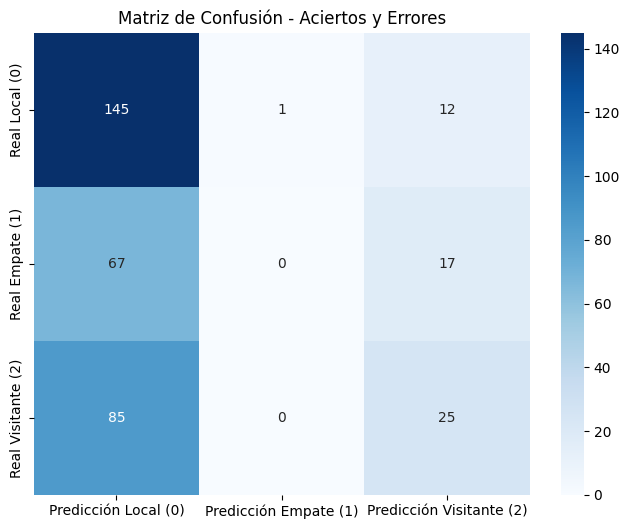

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# El modelo necesita elegir una sola opción (0, 1 o 2) para poder contar los aciertos
predicciones_test = modelo_calibrado.predict(X_test)

# Calculamos la matriz cruzando la realidad (y_test) con la predicción
matriz = confusion_matrix(y_test, predicciones_test)

# Configuramos el diseño visual
plt.figure(figsize=(8, 6))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción Local (0)', 'Predicción Empate (1)', 'Predicción Visitante (2)'],
            yticklabels=['Real Local (0)', 'Real Empate (1)', 'Real Visitante (2)'])
plt.title('Matriz de Confusión - Aciertos y Errores')
plt.show()

In [ ]:
import joblib
# Empaquetamos todo lo que la web necesita para pensar por sí misma
datos_para_web = {
    'modelo': modelo_calibrado,
    'elo_diccionario': elo_diccionario,
    'media_goles': media_goles_global,
    # Guardamos solo las columnas clave del historial para que el archivo no pese mucho
    'historial': df_limpio[['HomeTeam', 'AwayTeam', 'Ataque_Local_5p', 'Defensa_Local_5p', 'Ataque_Visitante_5p', 'Defensa_Visitante_5p']]
}

# Creamos el archivo "empaquetado"
joblib.dump(datos_para_web, 'modelo_laliga_v1.pkl')

print("¡Archivo 'modelo_laliga_v1.pkl' creado! Descárgalo desde la carpeta izquierda de Colab.")

¡Archivo 'modelo_laliga_v1.pkl' creado! Descárgalo desde la carpeta izquierda de Colab.
